In [12]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from deep_hvac import simulator, util


ppo_results_frame = pd.read_pickle('ppo_results_frame.pickle')
ppobc_results_frame = pd.read_pickle('ppobc_results_frame.pickle')

expert = pd.read_pickle('../data/results-expert-medium-summer.pickle')
expert_frame = util.load_expert_performance(expert)

def unpivot(frame, start=None, end=None):
    frame = frame.copy()
    frame = frame.swaplevel(-3, -1, axis=1)
    trials = frame.columns.get_level_values(0).unique()
    seeds = frame.columns.get_level_values(1).unique()
    to_concat = []
    for trial, seed in itertools.product(trials, seeds):
        subframe = frame[(trial, seed)].reset_index()
        subframe['trial'] = trial
        subframe['seed'] = seed
        to_concat.append(subframe)
    return pd.concat(to_concat)


def comfort_violations(frame):
    """Return dataframe with comfort penalty scores."""
    frame = frame.copy()
    frame['occupied'] =  [
        simulator.is_occupied(ts) for ts in frame.index
    ]
    if isinstance(frame.columns, pd.MultiIndex):
        for episode in frame['t_outside'].columns:
            frame[('comfort_penalty', episode)] = frame.apply(
                lambda row: (simulator.comfort_penalty(
                    row['t_outside'][episode],
                    row['t_inside'][episode]) * row['occupied'][0]),
                axis=1
            )
            frame[('comfort violation severe', episode)] = (
                frame[('comfort_penalty', episode)] >= 1
            )
            frame[('comfort violation moderate', episode)] = (
                (frame[('comfort_penalty', episode)] < 1) &
                (frame[('comfort_penalty', episode)] >= 0.5)
            )
    else:
        frame['comfort_penalty'] = frame.apply(
            lambda row: simulator.comfort_penalty(
                row['t_outside'], row['t_inside']
            ) * row['occupied'], axis=1
        )
        frame['comfort violation severe'] = (
            frame['comfort_penalty'] >= 1
        )
        frame['comfort violation moderate'] = (
            (frame['comfort_penalty'] < 1) &
            (frame['comfort_penalty'] >= 0.5)
        )

    return frame



ppo_results_long = unpivot(ppo_results_frame)
ppobc_results_long = unpivot(ppobc_results_frame)

ppo_results_long = comfort_violations(ppo_results_long.set_index('index')).reset_index()
ppobc_results_long = comfort_violations(ppobc_results_long.set_index('index')).reset_index()

ppo_results_long = ppo_results_long.query("seed == 'seed_1'").set_index('index')
ppobc_results_long = ppobc_results_long.query("seed == 'seed_1'").set_index('index')

/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


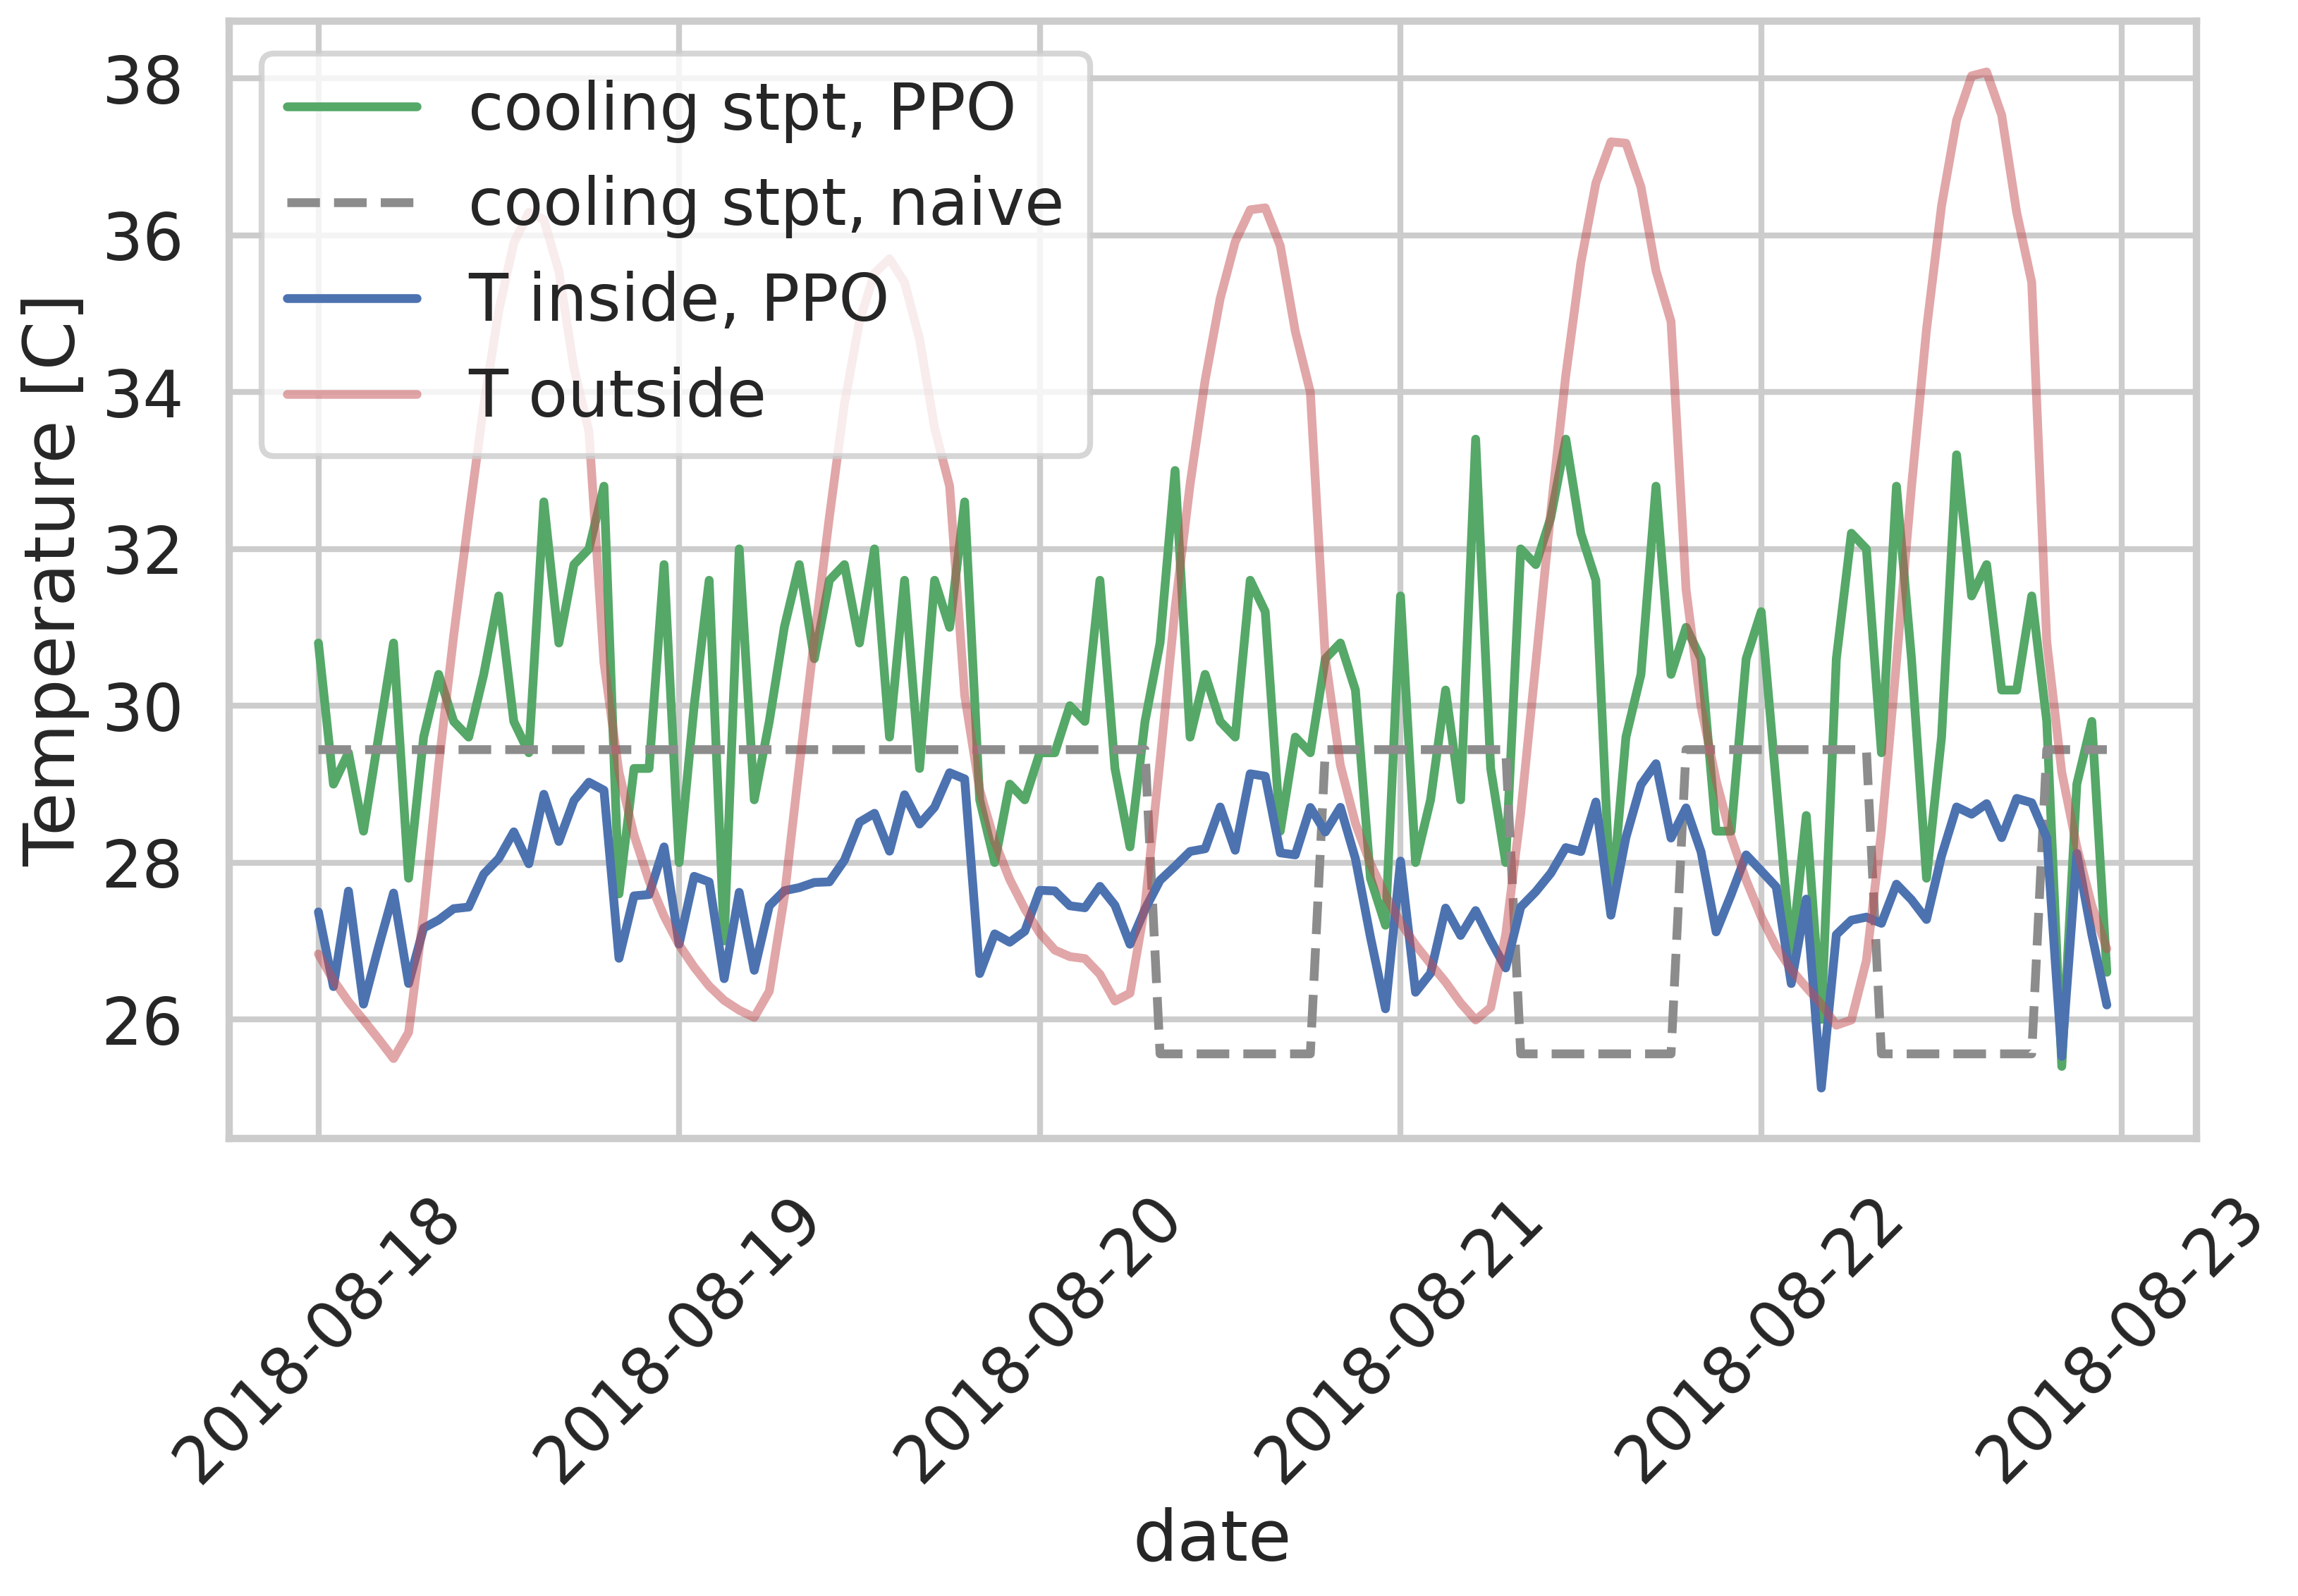

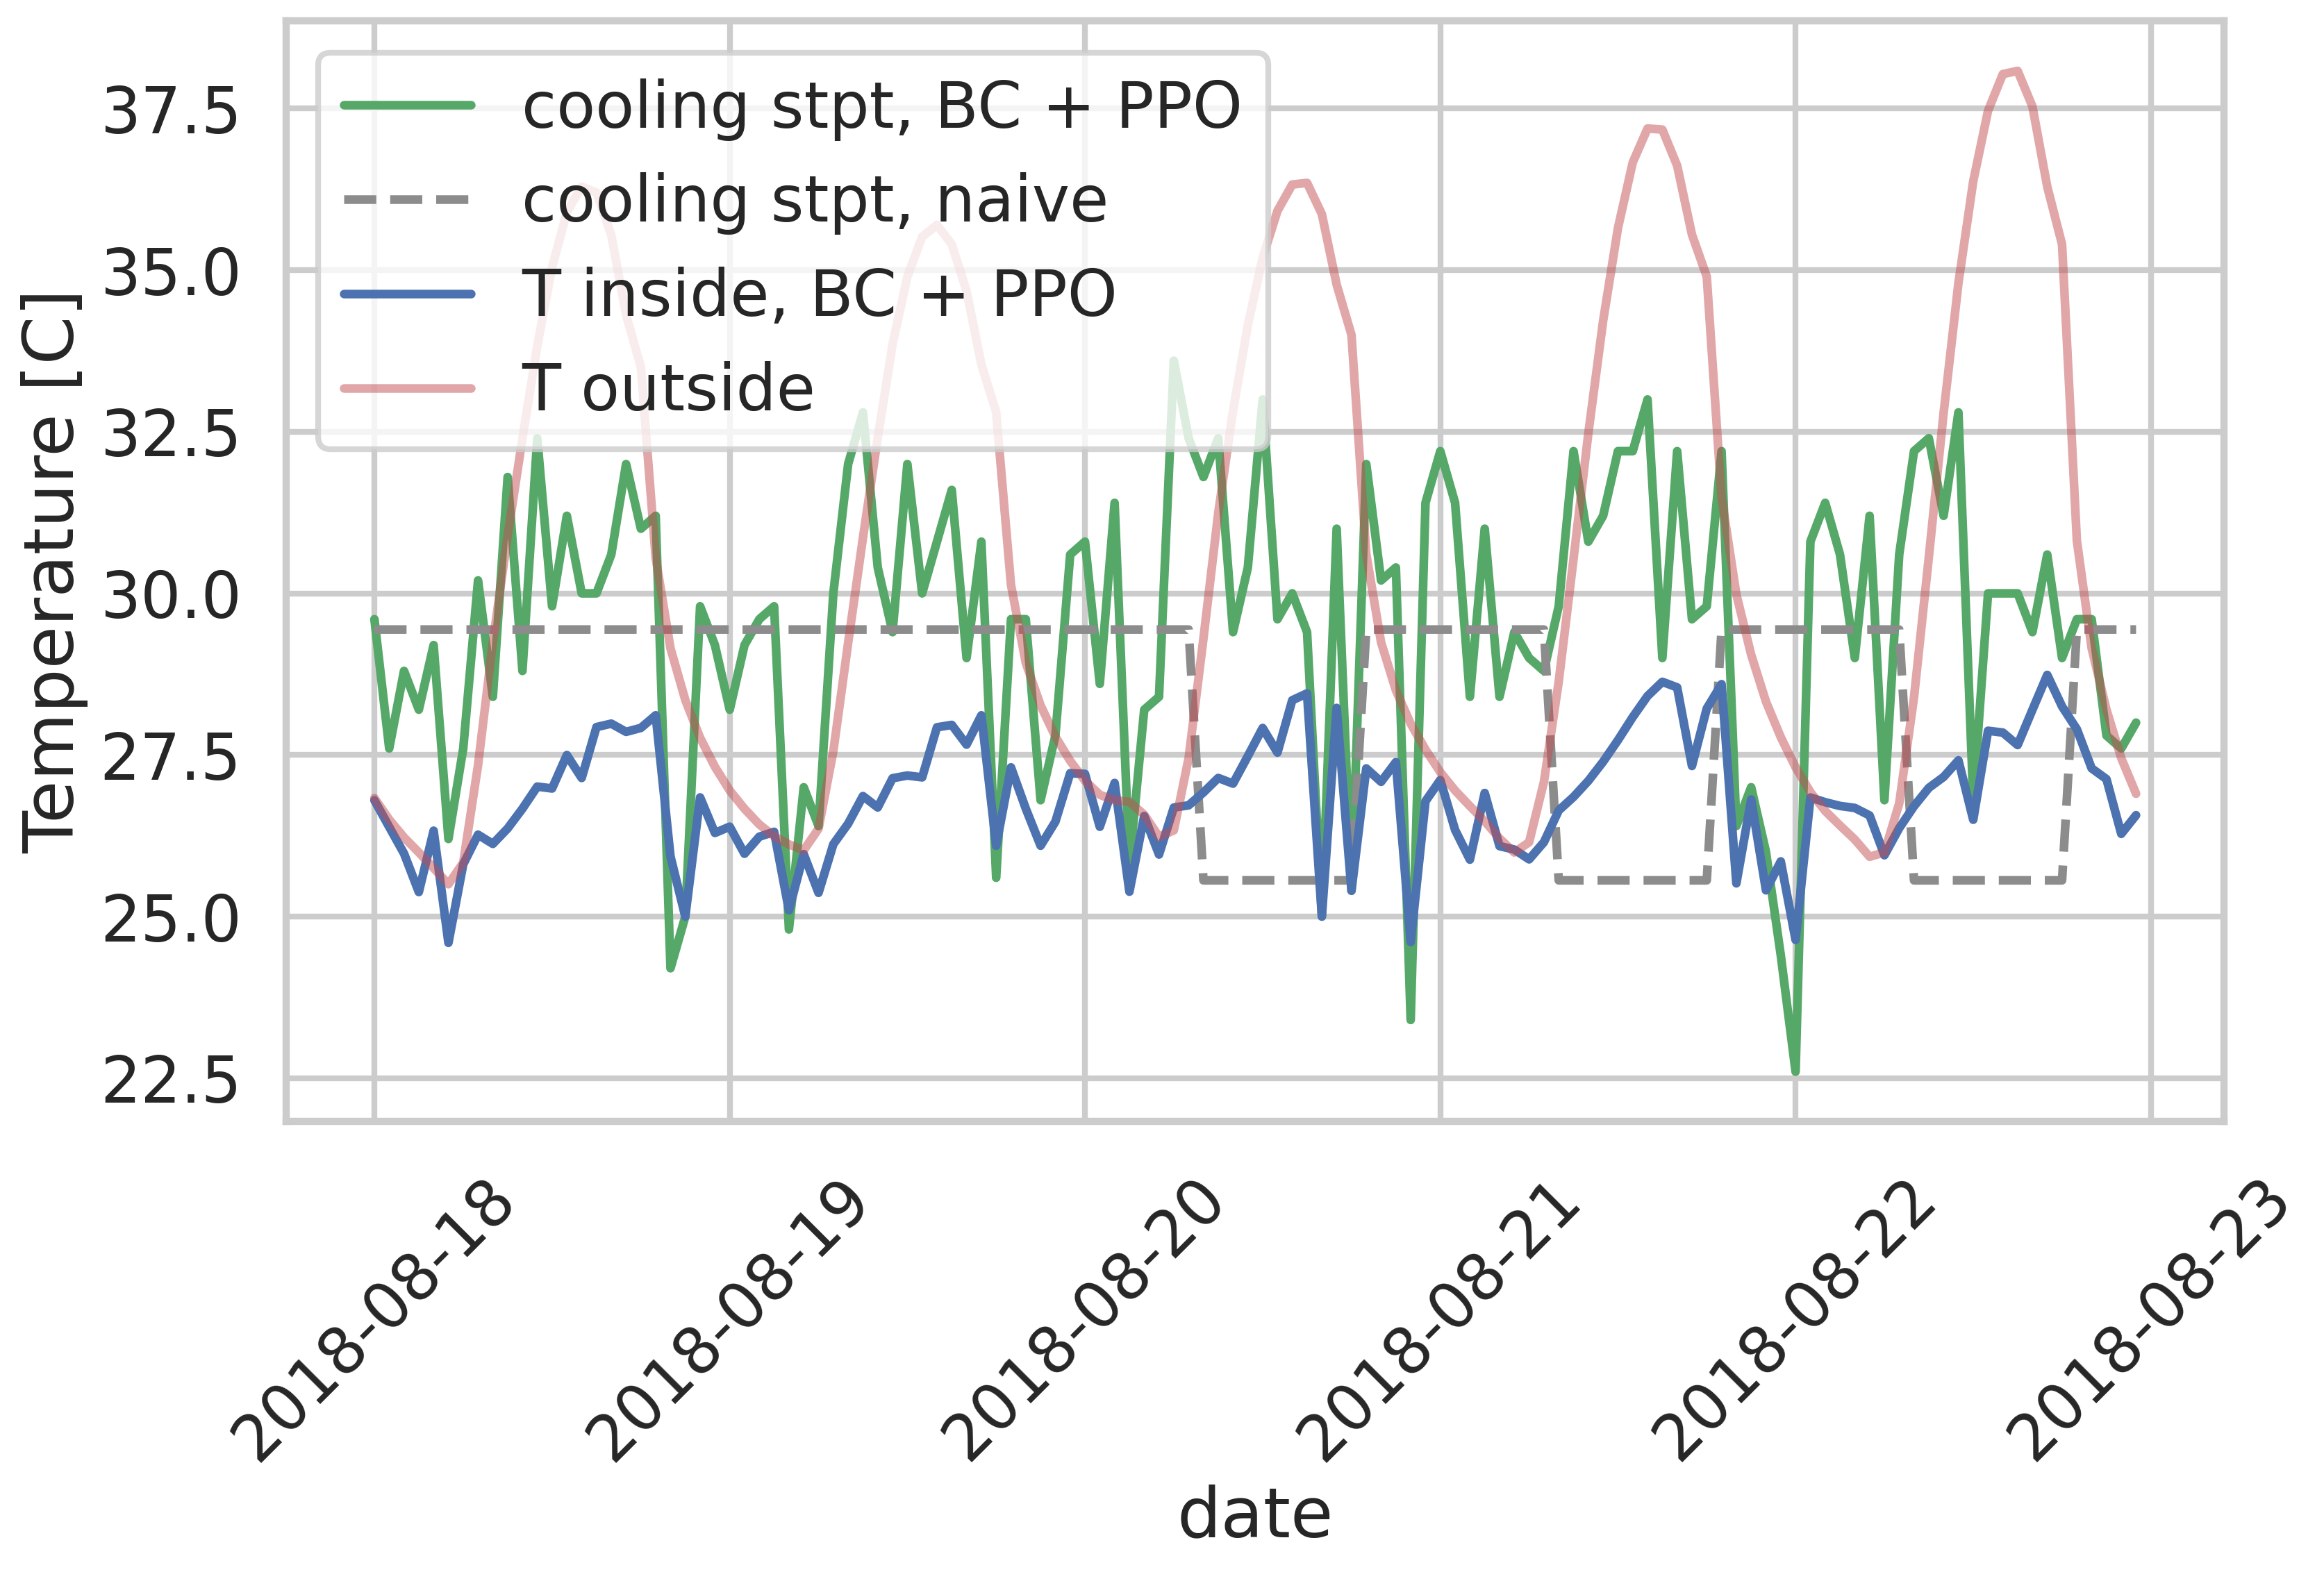

In [15]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

sns.set('poster')
sns.set_style('whitegrid')
start = '2018-08-18'
end = '2018-08-22'

blue = sns.color_palette()[0]
green = sns.color_palette()[2]
red = sns.color_palette()[3]
grey = sns.color_palette()[7]
aqua = sns.color_palette()[9]

expert_subset = expert_frame.loc[start:end]


def temperature_plot(rl_results, expert, start, end, modeltype='PPO'):
    expert_subset = expert.loc[start:end]
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    sns.lineplot(data=rl_results.loc[start:end].reset_index(),
                 x='index', y='set_cooling', color=green,
                 ci=None,
                 label=f'cooling stpt, {modeltype}',
                 ax=ax)
    ax.plot(expert_subset.index, expert_subset['set_cooling'],
             color=grey, linestyle='dashed',
             label='cooling stpt, naive')
    sns.lineplot(data=rl_results.loc[start:end].reset_index(),
                 x='index', y='t_inside', color=blue, ci=None,
                 label=f'T inside, {modeltype}', ax=ax)
    ax.plot(expert_subset.index, expert_subset['t_outside'],
             color=red, label='T outside', alpha=0.5)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('Temperature [C]')

temperature_plot(ppo_results_long, expert_frame, start, end,
                 'PPO')
temperature_plot(ppobc_results_long, expert_frame, start, end,
                 'BC + PPO')